Take the list of Kepler low mass stars (Teff < 4700 K) with at least one confirmed planet and cross-match it with the GAIA DR2 using Megan Bedell's catalog. Then retrieve all 2MASS photometry and compute the stellar parameters.<br>
There should be GAIA-derived parameters for at least 371/386 (96%) of the Kepler low mass stars with confirmed planets.

In [1]:
from imports import *
from scipy.interpolate import LinearNDInterpolator as lint
import mwdust, rvs
from get_Kepler_Mdwarf_planets import *
from estimate_PDF import *
%matplotlib inline


Bad key "xtick.labeltop" on line 358 in
/Users/ryancloutier/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/Users/ryancloutier/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [30]:
# define some useful functions
def _get_results(samples):
    v = np.percentile(samples, (16,50,84))
    return v[1], v[2]-v[1], v[1]-v[0]
    

def _get_2MASS_Kep(ras_deg, decs_deg, Jmags, Hmags, Kmags,
                   radius_deg=.017, phot_rtol=.02):
    '''Match Kepler stars with GAIA data to the 2MASS point-source catlog to
    retrieve photometric uncertainties.'''
    # get 2MASS data for Kepler stars
    # https://irsa.ipac.caltech.edu/applications/Gator/
    d = np.load('../GAIAMdwarfs/input_data/Keplertargets/fp_2mass.fp_psc12298.npy')
    inds = np.array([0,1,3,5,6,8,9,11])
    ras2M, decs2M, J2M, eJ2M, H2M, eH2M, K2M, eK2M = d[:,inds].T

    # match each star individually
    Nstars = ras_deg.size
    e_Jmags, e_Hmags, e_Kmags = np.zeros(Nstars), np.zeros(Nstars), \
                                np.zeros(Nstars)
    for i in range(Nstars):

        #if i % 1e2 == 0:
        #    print float(i) / Nstars

        # get matching photometry between Kepler-GAIA and 2MASS
        g = (ras2M >= ras_deg[i] - radius_deg) & \
            (ras2M <= ras_deg[i] + radius_deg) & \
            (decs2M >= decs_deg[i] - radius_deg) & \
            (decs2M <= decs_deg[i] + radius_deg) & \
            np.isclose(J2M, Jmags[i], rtol=phot_rtol) & \
            np.isclose(H2M, Hmags[i], rtol=phot_rtol) & \
            np.isclose(K2M, Kmags[i], rtol=phot_rtol)

        if g.sum() > 0:
            g2 = (abs(J2M[g]-Jmags[i]) == np.min(abs(J2M[g]-Jmags[i]))) & \
                 (abs(K2M[g]-Kmags[i]) == np.min(abs(K2M[g]-Kmags[i])))
            e_Jmags[i] = eJ2M[g][g2][0]
            e_Hmags[i] = eH2M[g][g2][0]
            e_Kmags[i] = eK2M[g][g2][0]

        else:
            e_Jmags[i], e_Hmags[i], e_Kmags[i] = np.repeat(np.nan, 3)
        
    return e_Jmags, e_Hmags, e_Kmags



def _compute_AK_mwdust(ls, bs, dist, edist, eAK_frac=.3, RV=3.1):
    '''Using the EB-V map from 2014MNRAS.443.2907S and the extinction vector
    RK = 0.31 from Schlafly and Finkbeiner 2011 (ApJ 737, 103). 
    Where does RV=3.1 come from? See the MIST BC tables where RV is fixed to 3.1'''
    dustmapK = mwdust.Combined15(filter='2MASS Ks')
    dustmapV = mwdust.Combined15(filter=None)  # returns E(B-V) rather than A_lambda
    dist_kpc, edist_kpc = np.ascontiguousarray(dist)*1e-3, \
                          np.ascontiguousarray(edist)*1e-3
    ls, bs = np.ascontiguousarray(ls), np.ascontiguousarray(bs)
    AK, eAK = np.zeros(ls.size), np.zeros(ls.size)
    AV = np.zeros(ls.size)
    for i in range(ls.size):
        v = dustmapK(ls[i], bs[i],
                     np.array([dist_kpc[i], dist_kpc[i]+edist_kpc[i]]))
        AK[i], eAK[i] = v[0], np.sqrt(abs(np.diff(v))**2 + (eAK_frac*v[0])**2)
        v = dustmapV(ls[i], bs[i],
                     np.array([dist_kpc[i], dist_kpc[i]+edist_kpc[i]]))
        AV[i] = v[0]*RV
    return AK, eAK, AV



def _sample_Rs_from_MK_Mdwarfs(samp_MK):
    '''Use relation from Mann+2015 (table 1) for M dwarfs'''
    assert (np.median(samp_MK) >= 4.6) & (np.median(samp_MK) <= 9.8) 
    a, b, c, Rs_sigma_frac = 1.9515, -.3520, .01680, .0289
    p = np.poly1d((c,b,a))
    samp_MK_tmp = np.copy(samp_MK)
    #samp_MK_tmp[(samp_MK<=4.6) | (samp_MK>=9.8)] = np.nan
    samp_Rs = p(samp_MK_tmp)
    samp_Rs += np.random.normal(0, samp_Rs*Rs_sigma_frac, samp_MK.size)
    return samp_Rs


def _sample_Rs_from_MK_Kdwarfs(samp_MK, samp_Teff, theta):
    '''Use MIST bolometric corrections for stars earlier than M dwarfs.
    theta (most likely values) = Teff, e_Teff, logg, Fe/H, Av'''
    assert len(theta) == 5
    assert np.median(samp_MK) < 4.6
    
    # get bolometric correction from MIST models
    BCK, eBCK = _interpolate_BCK(*theta)
    samp_BCK = np.random.randn(samp_MK.size)*eBCK + BCK
    samp_Mbol = samp_MK + samp_BCK
    
    # compute Rstar
    samp_Lbol = 3.0128e28 * 10**(-.4*samp_Mbol)  # Watts
    sigma = 5.670367e-8
    samp_Rs = rvs.m2Rsun(np.sqrt(samp_Lbol / (4*np.pi*sigma*samp_Teff**4)))
    return samp_Rs, BCK, eBCK


def _sample_Teff_from_colors(samp_GBPmag, samp_GRPmag, samp_Jmag, samp_Hmag,
                             Teff_scatter=49):
    '''Use the relation from Mann+2015 (table 2)'''
    a, b, c, d, e, f, g = 3.172, -2.475, 1.082, -.2231, .01738, .08776, -.04355
    pG = np.poly1d((e,d,c,b,a))
    p2 = np.poly1d((g,f,0))
    samp_Teff = 35e2 * (pG(samp_GBPmag-samp_GRPmag) + p2(samp_Jmag-samp_Hmag)) \
                + np.random.normal(0, Teff_scatter, samp_Jmag.size)
    return samp_Teff


def _sample_Ms_from_MK(samp_MK):
    '''Use relation from Benedict+2016'''
    c0 = np.random.normal(.2311, 4e-4, samp_MK.size)
    c1 = np.random.normal(-.1352, 7e-4, samp_MK.size)
    c2 = np.random.normal(.04, 5e-4, samp_MK.size)
    c3 = np.random.normal(.0038, 2e-4, samp_MK.size)
    c4 = np.random.normal(-.0032, 1e-4, samp_MK.size)
    samp_MK_tmp = np.copy(samp_MK)
    #samp_MK_tmp[(samp_MK<=4.6) | (samp_MK>10)] = np.nan
    #samp_MK_tmp[samp_MK>=10] = np.nan
    dMK = samp_MK_tmp - 7.5
    #samp_Ms = c0 + c1*dMK + c2*dMK**2 + c3*dMK**3 + c4*dMK**4
    # dont care about Ms for this work so don't both distinguishing between M dwarfs and earlier stars
    samp_Ms = np.repeat(samp_MK.size, np.nan)
    return samp_Ms


def _sample_logg(samp_Ms, samp_Rs):
    G = 6.67e-11
    samp_logg = np.log10(G*rvs.Msun2kg(samp_Ms)*1e2 / rvs.Rsun2m(samp_Rs)**2)
    return samp_logg


def _interpolate_BCK(Teff, e_Teff, logg, FeH, Av):
    '''Interpolate the MIST bolometric correction grids to get a star's K-band bolometric correction.'''
    # select a metallicity grid
    FeHgrid = np.array([-4,-3.5,-3,-2.75,-2.5,-2.25,-2,-1.75,-1.5,-1.25,-1,-.75,-.5,-.25,0,.25,.5,.75])
    inds, coeffs = _get_interpolation_coeffs(FeHgrid, FeH)
    if np.any(coeffs == 0):
        FeHs = FeHgrid[inds[coeffs>0]]
        coeffs = np.ones(1)
    else:
        FeHs = FeHgrid[inds]
    
    # interpolate over remaining parameters for all metallicity grids and with sampled Teff
    BCKs = np.zeros((FeHs.size, 2))
    for i in range(FeHs.size):
        
        # get BC grid for a fixed Fe/H
        label = 'p' if FeHs[i] >= 0 else 'm'
        fname = 'UBVRIplus/feh%s%.3d.UBVRIplus'%(label, abs(FeHs[i])*1e2)
        Teffgrid, logggrid, Avgrid, BCKgrid  = np.loadtxt(fname, skiprows=5, usecols=(0,1,3,12)).T
        
        # compute a separate BCK for Teff across its 1 sigma uncertainty to estimate the uncertainty in BCK
        # because it is dominated by uncertainies in Teff which have the strongest effect on the stellar SED
        BCKs_Teff, j = np.zeros(0), 0
        for t in Teff+np.arange(2)*e_Teff:
            # interpolate to get BCK
            lint_BCK = lint(np.array([Teffgrid,logggrid,Avgrid]).T, BCKgrid)
            BCKs[i,j] = np.append(BCKs_Teff, float(lint_BCK(t, logg, Av)) * coeffs[i])
            j += 1
            
    # sum contributions from each Fe/H
    BCKs = np.sum(BCKs, axis=0)
    assert BCKs.size == 2
    BCK, e_BCK = BCKs[0], abs(float(np.diff(BCKs)))
    return BCK, e_BCK

                     
def _get_interpolation_coeffs(arr, val):
    if val < arr.min():
        return np.argsort(arr)[:1], np.ones(1)
    elif val > arr.max():
        return np.argsort(arr)[-1:], np.ones(1)
    else:
        edgeinds = np.argsort(abs(arr-val))[:2]
        edgevals = arr[edgeinds]
        diff = abs(float(np.diff(edgevals)))
        c1 = abs(val-edgevals[0]) / diff
        coeffs = np.array([1-c1, c1]).reshape(2)
        return edgeinds, coeffs
   

def _check_Teffs(Teff_K, ehi_Teff, elo_Teff):
    if elo_Teff > 1e4:
        elo_Teff = ehi_Teff
    return Teff_K, ehi_Teff, elo_Teff

In [23]:
# get Kepler IDs of potential stars of interest confirmed planets
KepMdwarffilein = 'Keplertargets/NASAarchive_confirmed_Keplerlowmassstars.csv'
kepidsM = np.loadtxt(KepMdwarffilein, delimiter=',', skiprows=66, usecols=(1))
N = kepidsM.size
print N

386


In [4]:
# get megan bedell catalog
hdu = fits.open('../GAIAMdwarfs/input_data/Keplertargets/kepler_dr2_4arcsec.fits')[1].data

In [5]:
# setup arrays
# diagnostic arrays
inGAIA = np.zeros(N, dtype=bool)
badGAIA, bad2MASS, baddistpost = np.zeros(N, dtype=bool), np.zeros(N, dtype=bool), np.zeros(N, dtype=bool)
isMdwarf, badTeff = np.zeros(N, dtype=bool), np.zeros(N, dtype=bool)

# parameters
nanarr = np.zeros(N) + np.nan
ras, decs = np.copy(nanarr), np.copy(nanarr)
GBPmag, e_GBPmag = np.copy(nanarr), np.copy(nanarr)
GRPmag, e_GRPmag = np.copy(nanarr), np.copy(nanarr)
Kepmag = np.copy(nanarr)
Jmag, e_Jmag = np.copy(nanarr), np.copy(nanarr)
Hmag, e_Hmag = np.copy(nanarr), np.copy(nanarr)
Kmag, e_Kmag = np.copy(nanarr), np.copy(nanarr)
parallax_mas, e_parallax = np.copy(nanarr), np.copy(nanarr)
dist_pc, ehi_dist, elo_dist = np.copy(nanarr), np.copy(nanarr), np.copy(nanarr)
mu, ehi_mu, elo_mu = np.copy(nanarr), np.copy(nanarr), np.copy(nanarr)
AK, e_AK = np.copy(nanarr), np.copy(nanarr)
BCK, e_BCK = np.copy(nanarr), np.copy(nanarr)
MK, ehi_MK, elo_MK = np.copy(nanarr), np.copy(nanarr), np.copy(nanarr)
Rs_RSun, ehi_Rs, elo_Rs = np.copy(nanarr), np.copy(nanarr), np.copy(nanarr)
Teff_K, ehi_Teff, elo_Teff = np.copy(nanarr), np.copy(nanarr), np.copy(nanarr)
Ms_MSun, ehi_Ms, elo_Ms = np.copy(nanarr), np.copy(nanarr), np.copy(nanarr)
logg_dex, ehi_logg, elo_logg = np.copy(nanarr), np.copy(nanarr), np.copy(nanarr)

In [31]:
# retrieve and compute stellar parameters
for i in range(77,N):

    # is this star in the GAIA-Kep catalog?
    print '\n', i, kepidsM[i]
    g = hdu['kepid'] == kepidsM[i]
    inGAIA[i] = g.sum() > 0

    if g.sum() == 0:    # star is not in GAIA
        continue
    
    elif g.sum() > 1:   # more than one potential source match
        ra = hdu['ra'][g]
        dec = hdu['dec'][g]
        print 'Multiple source matches:', kepidsM[i], ra, dec, hdu['parallax'][g]
        #index = int(raw_input('Which index is correct? '))
        index = int(np.argsort(hdu['parallax'][g])[-1])   # TEMP: take source with the largest parallax
        #index = 0 # TEMP
        
    else:
        index = 0
        
    # save some stellar parameters
    ras[i] = hdu['ra'][g][index]
    decs[i] = hdu['dec'][g][index]
    l, b = hdu['l'][g][index], hdu['b'][g][index]
    GBPmag[i] = hdu['phot_bp_mean_mag'][g][index]
    FBP = hdu['phot_bp_mean_flux'][g][index]
    eFBP = hdu['phot_bp_mean_flux_error'][g][index]
    e_GBPmag[i] = -2.5*np.log10(FBP / (FBP+eFBP))
    GRPmag[i] = hdu['phot_rp_mean_mag'][g][index]
    FRP = hdu['phot_rp_mean_flux'][g][index]
    eFRP = hdu['phot_rp_mean_flux_error'][g][index]
    e_GRPmag[i] = -2.5*np.log10(FRP / (FRP+eFRP))
    Kepmag[i] = hdu['kepmag'][g][index]
    Jmag[i] = hdu['jmag'][g][index]
    Hmag[i] = hdu['hmag'][g][index]
    Kmag[i] = hdu['kmag'][g][index]
    parallax_mas[i] = hdu['parallax'][g][index] + .029
    e_parallax[i] = hdu['parallax_error'][g][index]
    
    params = l,b,GBPmag[i],e_GBPmag[i],GRPmag[i],e_GRPmag[i],parallax_mas[i],e_parallax[i]
    if np.any(np.isnan(list(params))):
        print 'Bad GAIA params:', kepidsM[i], params
        badGAIA[i] = True
    
    Nsamp = 1000                 
    samp_GBP = np.random.randn(Nsamp)*e_GBPmag[i] + GBPmag[i]
    samp_GRP = np.random.randn(Nsamp)*e_GRPmag[i] + GRPmag[i]

    # get 2MASS photometric uncertainies
    p = _get_2MASS_Kep(ras[i:i+1], decs[i:i+1], Jmag[i:i+1], Hmag[i:i+1], Kmag[i:i+1])
    if np.any(np.isnan(p)):
        e_Hmag[i], e_Kmag[i] = np.repeat(e_Jmag[i],2)    
    else:
        e_Jmag[i], e_Hmag[i], e_Kmag[i] = p
    samp_J = np.random.randn(Nsamp)*e_Jmag[i] + Jmag[i]
    samp_H = np.random.randn(Nsamp)*e_Hmag[i] + Hmag[i]
    samp_K = np.random.randn(Nsamp)*e_Kmag[i] + Kmag[i]

    params = Jmag[i],e_Jmag[i],Hmag[i],e_Hmag[i],Kmag[i],e_Kmag[i]
    if np.any(np.isnan(list(params))):
        print 'Bad 2MASS params:', kepidsM, params
        bad2MASS[i] = True
    
    # get distance posteriors from Bailor-Jones
    try:
        fname='../GAIAMdwarfs/Gaia-DR2-distances_custom/DistancePosteriors/KepID_%i.csv'%(kepidsM[i])
        x_dist, pdf_dist = np.loadtxt(fname, delimiter=',', skiprows=1,
                                      usecols=(1,2)).T
        samp_dist = np.random.choice(x_dist, Nsamp, p=pdf_dist/pdf_dist.sum())
    except IOError:
        # print statement to be run in the script below: save_posteriors(IDnums, pars, e_pars, ls, bs, Kep=True)
        #print 'IDnums,pars,e_pars,ls,bs=np.array([%i]),np.array([%.8e]),np.array([%.8e]),np.array([%.8e]),np.array([%.8e])'%(kepids[i], parallax_mas[i], e_parallax[i], l, b)
        #raise ValueError('Need to compute the distance posterior for KepID_%i (see get_gaia_2MASS.save_posteriors())'%kepids[i])                    
        f = open('tocomputedistance.csv', 'a')
        f.write('%i,%.8e,%.8e,%.8e,%.8e\n'%(kepidsM[i], parallax_mas[i], e_parallax[i], l, b))
        f.close()
        samp_dist = np.repeat(np.nan, Nsamp)
        baddistpost[i] = True
        continue
            
    # compute stellar parameters
    dist_pc[i], ehi_dist[i], elo_dist[i] = _get_results(samp_dist.reshape(Nsamp,1))
    samp_mu = 5*np.log10(samp_dist) - 5
    mu[i], ehi_mu[i], elo_mu[i] = _get_results(samp_mu.reshape(Nsamp,1))
    AK[i], e_AK[i], Av = _compute_AK_mwdust(l, b, dist_pc[i], ehi_dist[i])
    samp_AK = np.random.randn(Nsamp)*e_AK[i] + AK[i]
    samp_MK = samp_K - samp_mu - samp_AK
    MK[i], ehi_MK[i], elo_MK[i] = _get_results(samp_MK.reshape(Nsamp,1))
    
    if (MK[i] >= 4.6) and (MK[i] <= 9.8):
        isMdwarf[i] = True
        print 'Is M dwarf.', MK[i]
        samp_Rs = _sample_Rs_from_MK_Mdwarfs(samp_MK)
        Rs_RSun[i], ehi_Rs[i], elo_Rs[i] = _get_results(samp_Rs.reshape(Nsamp,1))
        samp_Teff = _sample_Teff_from_colors(samp_GBP, samp_GRP, samp_J, samp_H)
        Teff_K[i], ehi_Teff[i], elo_Teff[i] = _get_results(samp_Teff.reshape(Nsamp,1))
        #samp_Ms = _sample_Ms_from_MK(samp_MK)
        #Ms_MSun[i], ehi_Ms[i], elo_Ms[i] = _get_results(samp_Ms.reshape(Nsamp,1))
        #samp_logg = _sample_logg(samp_Ms, samp_Rs)
        #logg_dex[i], ehi_logg[i], elo_logg[i] = _get_results(samp_logg.reshape(Nsamp,1))
    
    elif np.isfinite(np.median(samp_MK)):
        isMdwarf[i] = False
        print 'Not an M dwarf.', MK[i]
        Teff_K[i] = hdu['teff'][g][index]
        ehi_Teff[i] = hdu['teff_err1'][g][index]
        elo_Teff[i] = abs(hdu['teff_err2'][g][index])
        Teff_K[i], ehi_Teff[i], elo_Teff[i] = _check_Teffs(Teff_K[i], ehi_Teff[i], elo_Teff[i])
        if np.any(np.isnan(np.array([Teff_K[i], ehi_Teff[i], elo_Teff[i]]))): badTeff[i] = True 
        _,_,samp_Teff = get_samples_from_percentiles(Teff_K[i], ehi_Teff[i], elo_Teff[i], Nsamp=Nsamp)        
        theta = Teff_K[i], ehi_Teff[i], hdu['logg'][g][index], hdu['feh'][g][index], float(Av)
        samp_Rs,BCK[i],e_BCK[i] = _sample_Rs_from_MK_Kdwarfs(samp_MK, samp_Teff, theta)
        Rs_RSun[i], ehi_Rs[i], elo_Rs[i] = _get_results(samp_Rs.reshape(Nsamp,1))
        #samp_Ms = _sample_Ms_from_MK(samp_MK)
        #Ms_MSun[i], ehi_Ms[i], elo_Ms[i] = _get_results(samp_Ms.reshape(Nsamp,1))
        #samp_logg = _sample_logg(samp_Ms, samp_Rs)
        #logg_dex[i], ehi_logg[i], elo_logg[i] = _get_results(samp_logg.reshape(Nsamp,1))
        
    # save stellar posteriors
    samp_Ms, samp_logg = np.zeros(samp_Rs.size)+np.nan, np.zeros(samp_Rs.size)+np.nan
    allpost = np.array([samp_GBP,samp_GRP,samp_J,samp_H,samp_K,samp_dist,
                        samp_mu,samp_AK,samp_MK,samp_Rs,samp_Teff,samp_Ms,samp_logg])
    distoutname = '../GAIAMdwarfs/Gaia-DR2-distances_custom/DistancePosteriors/KepID_allpost_%i'%kepidsM[i]
    np.savetxt(distoutname, allpost.T, fmt='%.8e', delimiter=',')


77 5438099.0
Not an M dwarf. 4.034335034941587
4855.0 4955.0 5055.0

78 5456651.0
Not an M dwarf. 4.062976872979953
4860.0 4959.0 5058.0

79 5456651.0
Not an M dwarf. 4.0624475594667615
4860.0 4959.0 5058.0

80 5526527.0
Not an M dwarf. 4.595197894160091
4257.0 4334.0 4411.0

81 5531576.0
Not an M dwarf. 4.073766677848313
4683.0 4768.0 4844.0

82 5531576.0
Not an M dwarf. 4.0799859493406
4683.0 4768.0 4844.0

83 5617854.0
Is M dwarf. 4.880203013319022

84 5640085.0
Not an M dwarf. 4.474254815695357
3808.0 3893.0 3971.0

85 5640085.0
Not an M dwarf. 4.472552041883793
3808.0 3893.0 3971.0

86 5686174.0
Is M dwarf. 4.6227848535892155

87 5688790.0
Is M dwarf. 5.974558238401675

88 5706966.0
Multiple source matches: 5706966.0 [292.28612007 292.28566115] [40.91354289 40.91347351] [3.05372727 3.8129019 ]
Bad GAIA params: 5706966.0 (73.54689187310156, 10.864206034684061, nan, nan, nan, nan, 3.841901900533899, 0.43403660644192)
Is M dwarf. 4.913137917933603

89 5706966.0
Multiple source match

/Users/ryancloutier/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Is M dwarf. 4.917792145326558

90 5794240.0
Is M dwarf. 4.975216974412238

91 5794379.0
Not an M dwarf. 3.9480155527000464
4560.0 4702.0 4830.0

92 5794379.0
Not an M dwarf. 3.937982704626326
4560.0 4702.0 4830.0

93 5868793.0
Is M dwarf. 7.936908903034238

94 5940165.0
Not an M dwarf. 4.317675161974828
4325.0 4458.0 4591.0

95 5980208.0
Multiple source matches: 5980208.0 [297.07379283 297.07300801] [41.22446133 41.22532518] [3.10423724 0.22161533]
Is M dwarf. 4.7713388055667405

96 6020753.0
Not an M dwarf. 4.3521699347474385
4578.0 4671.0 4764.0

97 6020753.0
Not an M dwarf. 4.353856567796241
4578.0 4671.0 4764.0

98 6026438.0
Not an M dwarf. 4.42325101186549
4511.0 4650.0 4775.0

99 6026438.0
Not an M dwarf. 4.422655674713482
4511.0 4650.0 4775.0

100 6026438.0
Not an M dwarf. 4.424320623873798
4511.0 4650.0 4775.0

101 6063220.0
Not an M dwarf. 4.155140441709454
4688.0 4783.0 4878.0

102 6186964.0
Is M dwarf. 4.60319035556575

103 6198999.0
Multiple source matches: 6198999.0 [289.9

/Users/ryancloutier/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)



105 6263593.0

106 6382217.0
Is M dwarf. 4.852623746273643

107 6382217.0
Is M dwarf. 4.858367013325283

108 6425957.0
Multiple source matches: 6425957.0 [285.28669118 285.28782341] [41.86093567 41.86140062] [6.2320217  0.12937429]
Is M dwarf. 4.811277395825002

109 6425957.0
Multiple source matches: 6425957.0 [285.28669118 285.28782341] [41.86093567 41.86140062] [6.2320217  0.12937429]
Is M dwarf. 4.813627134228848

110 6435936.0
Is M dwarf. 5.313787482029693

111 6436029.0
Not an M dwarf. 4.471761951627092
4650.0 4817.0 5001.0

112 6444896.0
Is M dwarf. 7.762576178101305

113 6497146.0
Multiple source matches: 6497146.0 [281.64572365 281.64582311] [41.95106862 41.95216716] [5.10352835 1.26248582]
Is M dwarf. 4.741634984389702

114 6665512.0
Not an M dwarf. 3.7110715499076607
4329.0 4461.0 4593.0

115 6697756.0
Is M dwarf. 4.929588911111553

116 6773862.0
Is M dwarf. 4.852030567058369

117 6774537.0
Multiple source matches: 6774537.0 [290.91445158 290.91372666] [42.28655217 42.286185


213 8680979.0
Multiple source matches: 8680979.0 [288.44698786 288.44740349] [44.80126902 44.8017616 ] [-0.14779821  1.36526855]
Not an M dwarf. 3.969543019818337
4804.0 4891.0 4969.0

214 8733898.0
Is M dwarf. 7.90733914759943

215 8733898.0
Is M dwarf. 7.905951949343725

216 8733898.0
Is M dwarf. 7.90530030109782

217 8766650.0
Not an M dwarf. 4.094386346588081
4888.0 4987.0 5086.0

218 8826007.0
Multiple source matches: 8826007.0 [294.5536825  294.55378121] [45.0813011 45.0809308] [1.94862215 0.31815729]
Not an M dwarf. 4.376218737146684
4275.0 4406.0 4524.0

219 8845205.0
Is M dwarf. 6.246372241274273

220 8874090.0
Not an M dwarf. 4.461025580771366
3532.0 3751.0 3970.0

221 8890150.0
Is M dwarf. 4.803864584368787

222 8890150.0
Is M dwarf. 4.804162852040783

223 8892303.0
Multiple source matches: 8892303.0 [294.23735985 294.23720636] [45.19682738 45.19658297] [7.04290571 0.30027178]
Is M dwarf. 7.44530094999549

224 8978528.0
Not an M dwarf. 4.387754955704542
4065.0 4156.0 4239.0

Bad 2MASS params: [ 1873513.  2165002.  2165002.  2556650.  2581554.  2715135.  2975770.
  2987027.  3234598.  3234598.  3239945.  3239945.  3239945.  3245969.
  3426367.  3444588.  3546060.  3554031.  3554031.  3642335.  3728432.
  3733628.  3749365.  3859079.  3966801.  4049131.  4056616.  4139816.
  4139816.  4139816.  4139816.  4142847.  4180280.  4249725.  4249725.
  4263293.  4263293.  4263293.  4633570.  4633570.  4725681.  4725681.
  4736569.  4736644.  4813563.  4832837.  4852528.  4852528.  4852528.
  4852528.  4852528.  4913852.  4917596.  5080636.  5084942.  5164255.
  5175986.  5184911.  5185897.  5185897.  5185897.  5209845.  5252423.
  5252423.  5269467.  5340644.  5364071.  5364071.  5364071.  5364071.
  5371776.  5371776.  5371776.  5371776.  5438099.  5438099.  5438099.
  5438099.  5456651.  5456651.  5526527.  5531576.  5531576.  5617854.
  5640085.  5640085.  5686174.  5688790.  5706966.  5706966.  5794240.
  5794379.  5794379.  5868793.  5940165.  5980208.  6020753


354 11495458.0
Not an M dwarf. 4.532863202377117
4558.0 4641.0 4715.0

355 11497958.0

356 11497958.0

357 11497958.0

358 11497958.0

359 11497958.0

360 11551692.0
Multiple source matches: 11551692.0 [287.60500396 287.60570271] [49.52423845 49.52339369] [6.5557232  6.47831192]
Not an M dwarf. 4.149274178986309
4822.0 4920.0 5018.0

361 11551692.0
Multiple source matches: 11551692.0 [287.60500396 287.60570271] [49.52423845 49.52339369] [6.5557232  6.47831192]
Not an M dwarf. 4.149852782899046
4822.0 4920.0 5018.0

362 11611600.0
Not an M dwarf. 4.2727484038666255
4693.0 4838.0 4968.0

363 11622600.0
Is M dwarf. 4.645239320485317

364 11657614.0
Not an M dwarf. 4.285104466100591
4813.0 4891.0 4969.0

365 11670125.0
Not an M dwarf. 4.322130097360873
4714.0 4859.0 5004.0

366 11754553.0
Is M dwarf. 4.817894097201025

367 11754553.0
Is M dwarf. 4.818346682021545

368 11754553.0
Is M dwarf. 4.820652549695584

369 11768142.0

370 11774991.0
Not an M dwarf. 4.296872807296635
4750.0 4856.0 4

In [65]:
badGAIA.sum()

6

In [68]:
# save stellar data
hdr = 'KepID,isMdwarf,badGAIA,bad2MASS,baddistpost,badTeff,ra_deg,dec_deg,GBPmag,e_GBPmag,GRPmag,e_GRPmag,Kepmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,parallax_mas,e_parallax,dist_pc,ehi_dist,elo_dist,mu,ehi_mu,elo_mu,AK,e_AK,BCK,e_BCK,MK,ehi_MK,elo_MK,Rs_RSun,ehi_Rs,elo_Rs,Teff_K,ehi_Teff,elo_Teff,Ms_MSun,ehi_Ms,elo_Ms,logg_dex,ehi_logg,elo_logg'
outarr = np.array([kepidsM,isMdwarf,badGAIA,bad2MASS,baddistpost,badTeff,ras,decs,GBPmag,e_GBPmag,GRPmag,e_GRPmag,Kepmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,parallax_mas,e_parallax,dist_pc,ehi_dist,elo_dist,mu,ehi_mu,elo_mu,AK,e_AK,BCK,e_BCK,MK,ehi_MK,elo_MK,Rs_RSun,ehi_Rs,elo_Rs,Teff_K,ehi_Teff,elo_Teff,Ms_MSun,ehi_Ms,elo_Ms,logg_dex,ehi_logg,elo_logg])
_,g = np.unique(kepidsM, return_index=True)
fname = '../GAIAMdwarfs/input_data/Keplertargets/KepMdwarfsv11_archiveplanetsv2.csv'
np.savetxt(fname, outarr[:,g].T, delimiter=',', fmt='%.8e', header=hdr)

In [69]:
get_Kepler_Mdwarf_planets('Keplertargets/KepConfirmedMdwarfPlanets_v5')

0.0
1
1873513.0
1873513.0


/Users/ryancloutier/anaconda2/lib/python2.7/site-packages/rvs.py:53: RuntimeWarning: invalid value encountered in power
  return m2AU((G*(Ms+mp)*P*P / (4*np.pi*np.pi)) **(1./3))
get_Kepler_Mdwarf_planets.py:288: RuntimeWarning: invalid value encountered in sqrt
  


0.00460829493088
1
2556650.0
2556650.0
0.00921658986175
1
2715135.0
2715135.0
0.0138248847926
1
3426367.0
3426367.0
0.0184331797235
1
3444588.0
3444588.0
0.0230414746544
2
0.0276497695853
2
0.0322580645161
1
3642335.0
3642335.0
0.036866359447
1
3749365.0
3749365.0
0.0414746543779
1
3966801.0
3966801.0
0.0460829493088
4
0.0506912442396
4
0.0552995391705
4
0.0599078341014
4
0.0645161290323
2
0.0691244239631
2
0.073732718894
3
0.0783410138249
3
0.0829493087558
3
0.0875576036866
2
0.0921658986175
2
0.0967741935484
1
4832837.0
4832837.0
0.101382488479
5
0.10599078341
5
0.110599078341
5
0.115207373272
5
0.119815668203
5
0.124423963134
1
4913852.0
4913852.0
0.129032258065
1
4917596.0
4917596.0
0.133640552995
1
5080636.0
5080636.0
0.138248847926
3
0.142857142857
3
0.147465437788
3
0.152073732719
1
5209845.0
5209845.0
0.15668202765
1
5340644.0
5340644.0
0.161290322581
4
0.165898617512
4
0.170506912442
4
0.175115207373
4
0.179723502304
1
5526527.0
5526527.0
0.184331797235
1
5617854.0
5617854.0
0

In [81]:
# get object we just created
self = loadpickle('Keplertargets/KepConfirmedMdwarfPlanets_v5')

(None, None)

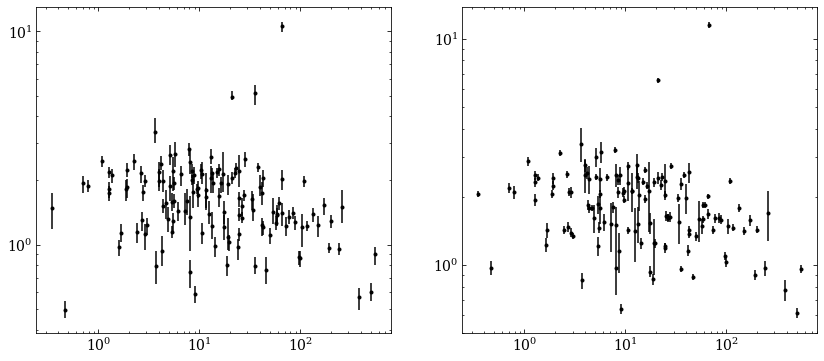

In [105]:
g = self.isMdwarf

plt.figure(figsize=(14,6))
plt.subplot(121)
plt.errorbar(self.Fs1[g], self.rps1[g], yerr=[self.elo_rps1[g], self.ehi_rps1[g]], fmt='k.')
plt.xscale('log'), plt.yscale('log')

plt.subplot(122)
Rss2 = unp.uarray(self.Rss2, self.ehi_Rss2)
rpRs = unp.uarray(self.rpRs, self.ehi_rpRs)
rps2 = rvs.m2Rearth(rpRs*rvs.Rsun2m(Rss2))
plt.errorbar(self.Fs1[g], unp.nominal_values(rps2)[g], unp.std_devs(rps2)[g], fmt='k.')
plt.xscale('log'), plt.yscale('log')